In [4]:
# all the imports
import pandas as pd
import matplotlib.pyplot as plt

import os
import glob

import numpy as np


In [5]:
def tidyAppOutput(file, evenlyIndex = True, sec = False):
    """
    Tidies the App Output to better plot in the next steps. Removes meta data and sets the timestaps as index.
    Timestamp is in msec, if not desired it can be changed to seconds here. But this results in slightly 
    different visualization in the next steps 
    --------------------
    Parameter:
        file: A pandas dataframe created from in the original app format
        evenlyIndex (boolean, default = True): If False timestamp from App is used as index, 
                                                if True an evenly spaced (4ms) index is created and used instead 
                                                True as default as this improves the signal quality. See Git for comparison. 
        sec (boolean): If true msec are transformed into seconds
        
        Returns:
        file: cleaned up dataframe
        
    """
    file = file.iloc[1:]
    file.columns = file.iloc[0]
    file = file[1:].apply(pd.to_numeric, errors='ignore')
    # to convert index to float
    flt_ind = file.index[:].tolist()
    file.index = [float(i) for i in flt_ind] # maken them float 
    
    # to evenly space the index:
    if evenlyIndex:
        length = len(file.index) # length of dataframe
        stop = length*4 # stop point 
        index_evenly = np.linspace(0, stop, num = length,endpoint = False)
        file.index = index_evenly # set evenly spaced array as index

    # to set index to seconds and not miliseconds
    if sec:
        sec_index = file.index[:].tolist()
        sec_index = [float(i) for i in sec_index]
        sec_index[:] = [x / 1000 for x in sec_index] #converts 
        file.index = sec_index
    
    return file

def plotTraceApp(df, channelname = ["Ch-1","Ch-2","Ch-3","Ch-4","Ch-5","Ch-6"], fro = 0, to = 1000, sec=False, title = "Experiment", save = False, saveas = "Experiment"):
    """
    Plots the trace from individual Traumschreiber channels. 
    --------------
    Parameter:
    df: a cleaned up dataframe containing the app output
    channelname: the channelname to be displayed (default all, select subset if required) 
    fro (int): Starting point to plot the trace (in msec). If that msec does not correspond to a measurement, the closest one is used 
    to (int): End of the plot in msec. If that msec does not correspond to a measurement, the closest one is used instead.
    sec (boolean): If index is in seconds (specified in tidyTSAppOutput), the axis label is changed 
    title: Title of the plot
    save (boolean): True if plot shall be saved (in working directory) as png
    saveas (string): Name of the saved file
    """
    
    try: #find the nearest timestamp (only possible when index is unique)
        start = df.index.get_loc(fro, method = "nearest")
        stop = df.index.get_loc(to, method = "nearest")
        
    except: #if the data is not evenly spaced, there might be dublicated timestamps. Hack-around required
        # assuming the start/end point is given in msec (specified in function description). 
        # In average there should be a new measurement every 4 msec (sampling rate 250 Hz).
        # We calculate the indices that roughly correspond to the desired starting and stopping msecs instead
        samplingInterval = 4 
        start = int(fro/samplingInterval)
        stop = int(to/samplingInterval) 
    toPlot = df.iloc[start:stop] # cut only relevant part of dataframe for plotting
    
    #to do: count # channels to be plotted and automatically adapt plot size
    
    toPlot.plot(y = channelname, grid = True, title = title, sharex = False, marker='o', figsize = (30,6), subplots = True) #removed figsize

    if sec:
        plt.xlabel('Seconds')
    else:
        plt.xlabel("msec")
    plt.ylabel("mVolt")
     
    if save:    
        plt.savefig(saveas+'.png') # saves as .png at the moment as was better for displaying/discussing in slack
    plt.show()


In [6]:
df_1 = tidyAppOutput(pd.read_csv("11-09-2020_16-03-09_exp1.csv"))
df_2 = tidyAppOutput(pd.read_csv("11-09-2020_16-04-17_exp2.csv"))
df_3 = tidyAppOutput(pd.read_csv("11-09-2020_16-05-00_exp3.csv"))


In [8]:
def read_PkgId(file):

    file = pd.read_csv(file)

    file = file.iloc[1:]
    file.columns = file.iloc[0]

    file = file[1:].apply(pd.to_numeric, errors='ignore')

    Pkg = file # too lazy to change names

    length = len(Pkg.index) # length of dataframe
    stop = length*4 # stop point 

    index_evenly = np.linspace(0, stop, num = length, endpoint = False) # to adapt timestamp  
    #print(Pkg.head())
    Pkg.loc[:,"Time"] = index_evenly #set the time as index, relevant for later plotting
    #print(Pkg.head())


    ids= Pkg.index.tolist() # these are all the package ids 
    #print(ids)
    Pkg['Pkg'] = Pkg.index

    Pkg.set_index('Time', inplace=True)
    return Pkg
#print(Pkg.head())

df1 = read_PkgId("11-09-2020_16-03-09_exp1.csv")
df2 = read_PkgId("11-09-2020_16-04-17_exp2.csv")
df3 = read_PkgId("11-09-2020_16-05-00_exp3.csv")



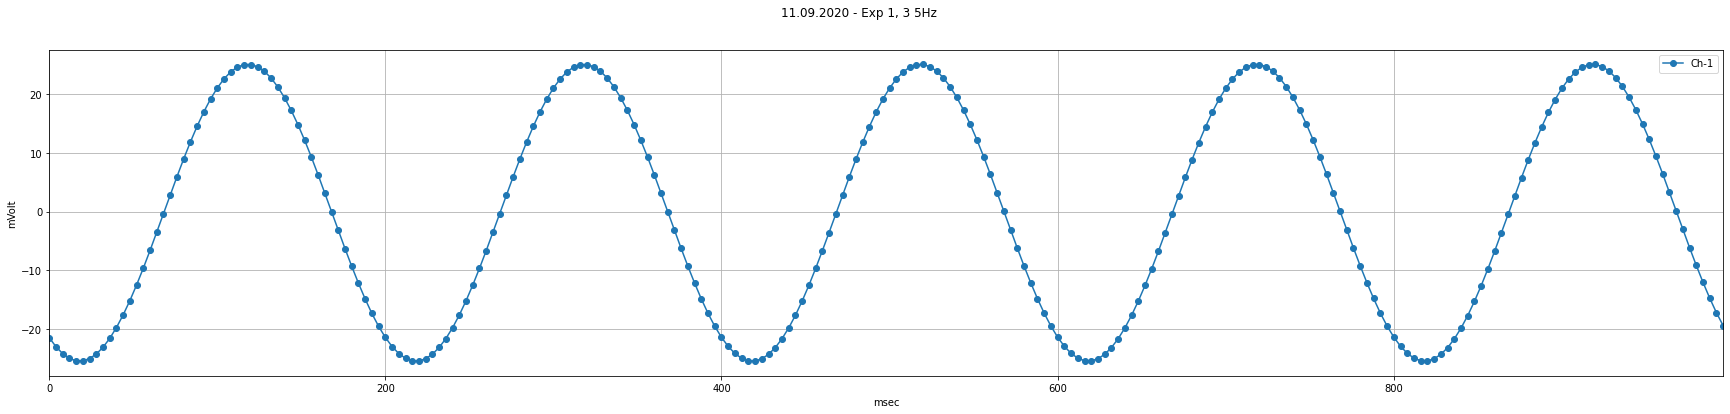

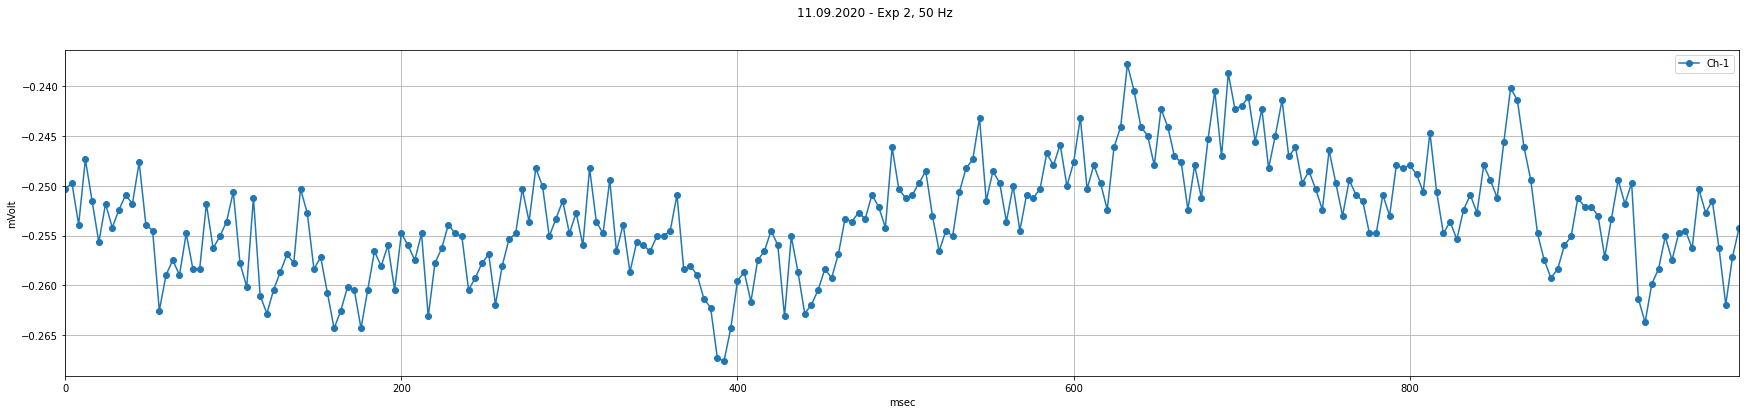

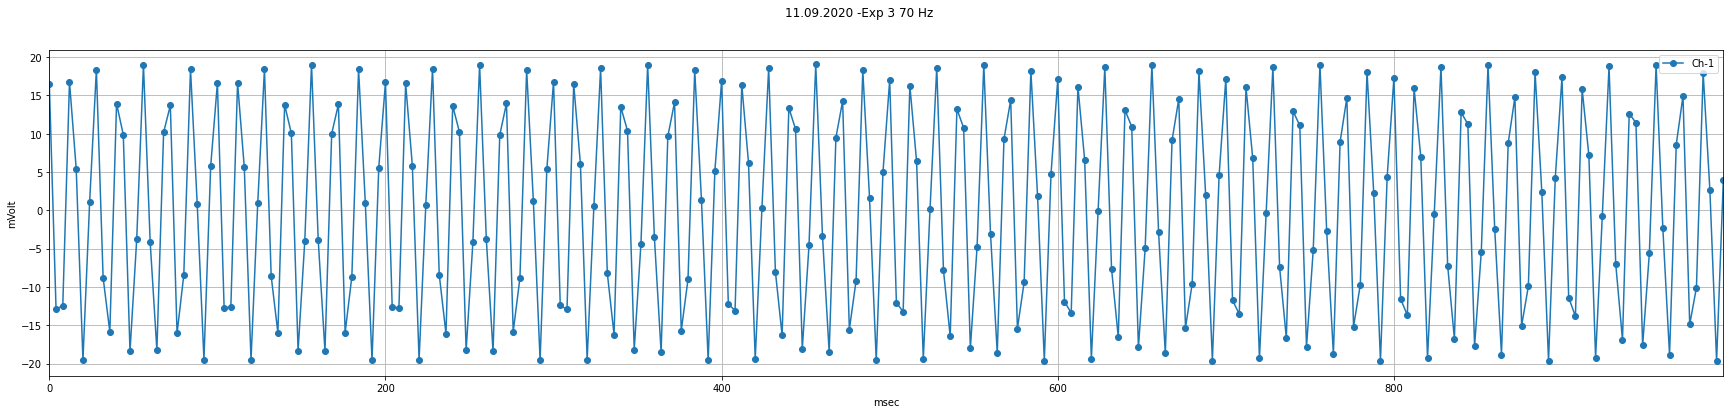

In [9]:
#print(df1)
plotTraceAp(df1, ["Ch-1"], title = "11.09.2020 - Exp 1, 3 5Hz")#, save= True, saveas = "Board03_22_09")
plotTraceAp(df2, ["Ch-1"], title = "11.09.2020 - Exp 2, 50 Hz")#, save= True, saveas = "FirstEOG")
plotTraceAp(df3, ["Ch-1"], title = "11.09.2020 -Exp 3 70 Hz")#, save= True, saveas = "Board03_50Hz_Filtered")
#plotTraceAp(df4, ["Ch-1"], title = "Exp 4 Board 3 50 Hz", save= True, saveas = "Board03_50Hz")

5 Hz looks goood, 50 Hz is nearly completely filtered out, 70 Hz is not smooth but this is probably due to the sampling rate. 